# Garbage Class Classifier



## Download and Prepare the Dataset

Use the [Garbage Classification dataset](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification), a gallery of Garbage images contains 6 classifications: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127).

In [1]:
import zipfile

# Extract the archive
local_zip = './archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/all')
zip_ref.close()


In [2]:
#remove the trash class
import shutil
path = './tmp/all/Garbage classification/Garbage classification/trash'

try:
   shutil.rmtree(path)
   print("directory is removed successfully")
except OSError as x:
   print("Error occured: %s : %s" % (path, x.strerror))

directory is removed successfully


In [3]:
import splitfolders # or import splitfolders
#split 
input_folder = "./tmp/all/Garbage classification/Garbage classification"
output = "./tmp/splitted/" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.85, .15)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

In [4]:
import os

base_dir = './tmp/splitted/train'

cardboard_dir = os.path.join(base_dir, 'cardboard')
glass_dir = os.path.join(base_dir, 'glass')
metal_dir = os.path.join(base_dir, 'metal')
paper_dir = os.path.join(base_dir, 'paper')
plastic_dir = os.path.join(base_dir, 'plastic')

print('total training cardboard images:', len(os.listdir(cardboard_dir)))
print('total training glass images:', len(os.listdir(glass_dir)))
print('total training metal images:', len(os.listdir(metal_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training plastic images:', len(os.listdir(plastic_dir)))

cardboard_files = os.listdir(cardboard_dir)
print(cardboard_files[:10])

glass_files = os.listdir(glass_dir)
print(glass_files[:10])

metal_files = os.listdir(metal_dir)
print(metal_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

plastic_files = os.listdir(plastic_dir)
print(plastic_files[:10])

total training cardboard images: 342
total training glass images: 425
total training metal images: 348
total training paper images: 504
total training plastic images: 409
['cardboard1.jpg', 'cardboard10.jpg', 'cardboard100.jpg', 'cardboard102.jpg', 'cardboard103.jpg', 'cardboard104.jpg', 'cardboard105.jpg', 'cardboard106.jpg', 'cardboard107.jpg', 'cardboard108.jpg']
['glass1.jpg', 'glass10.jpg', 'glass100.jpg', 'glass102.jpg', 'glass103.jpg', 'glass104.jpg', 'glass105.jpg', 'glass106.jpg', 'glass107.jpg', 'glass108.jpg']
['metal1.jpg', 'metal10.jpg', 'metal100.jpg', 'metal102.jpg', 'metal103.jpg', 'metal104.jpg', 'metal105.jpg', 'metal106.jpg', 'metal107.jpg', 'metal108.jpg']
['paper1.jpg', 'paper10.jpg', 'paper100.jpg', 'paper101.jpg', 'paper102.jpg', 'paper103.jpg', 'paper105.jpg', 'paper106.jpg', 'paper107.jpg', 'paper108.jpg']
['plastic1.jpg', 'plastic10.jpg', 'plastic100.jpg', 'plastic102.jpg', 'plastic103.jpg', 'plastic104.jpg', 'plastic105.jpg', 'plastic106.jpg', 'plastic107.jpg

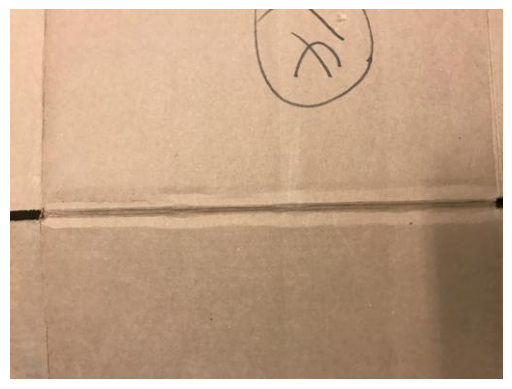

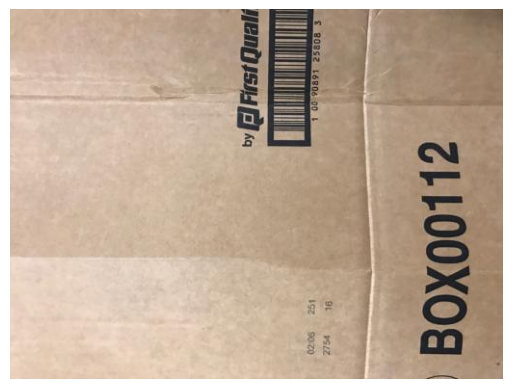

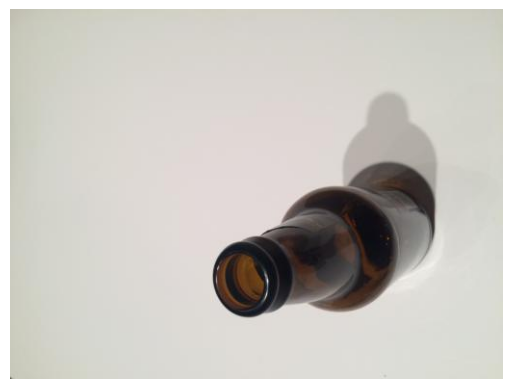

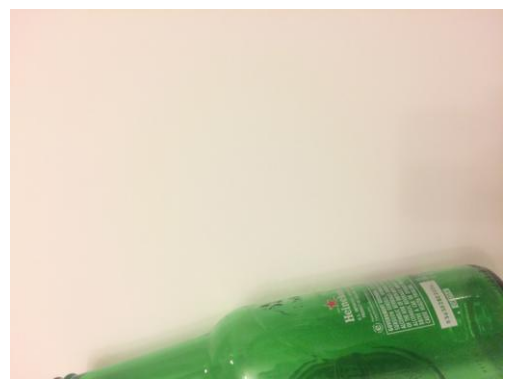

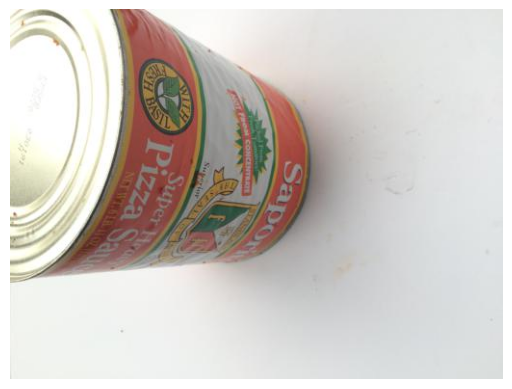

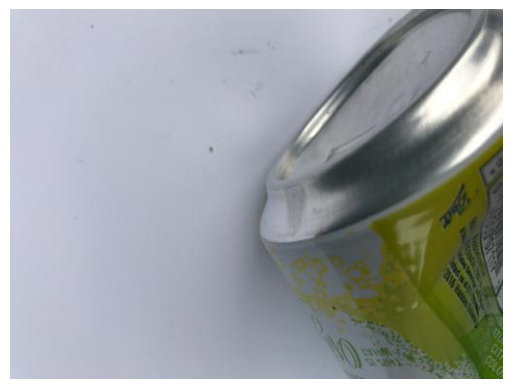

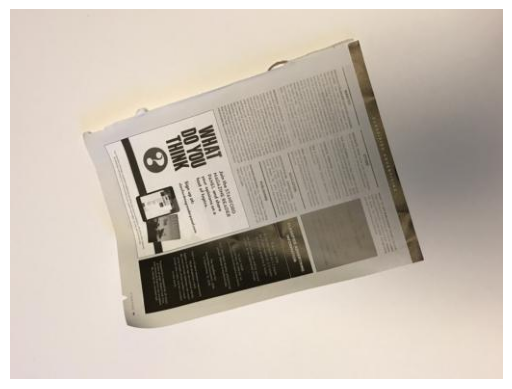

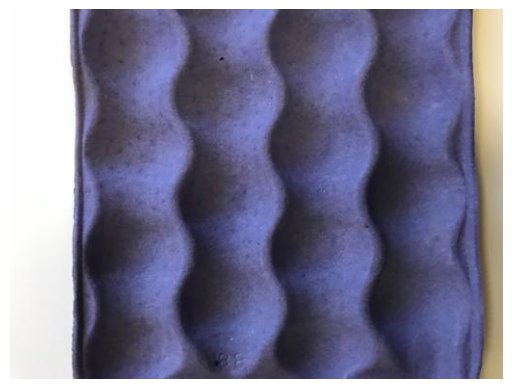

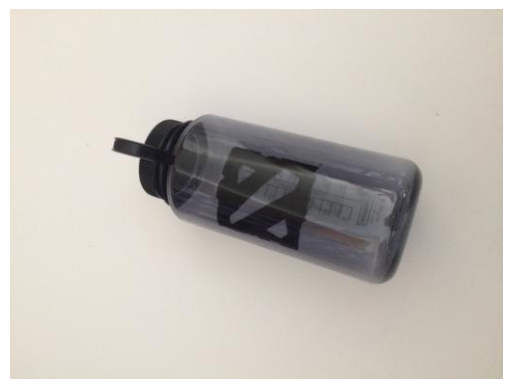

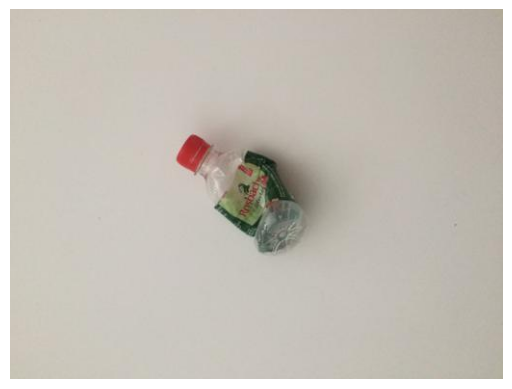

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_cardboard = [os.path.join(cardboard_dir, fname) 
                for fname in cardboard_files[pic_index-2:pic_index]]
next_glass = [os.path.join(glass_dir, fname) 
                for fname in glass_files[pic_index-2:pic_index]]
next_metal = [os.path.join(metal_dir, fname) 
                for fname in metal_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_plastic = [os.path.join(plastic_dir, fname) 
                for fname in plastic_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_cardboard+next_glass+next_metal+next_paper+next_plastic):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Prepare the ImageDataGenerator


In [6]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "./tmp/splitted/train"
training_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

VALIDATION_DIR = "./tmp/splitted/val"
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 1828 images belonging to 5 classes.
Found 35 images belonging to 5 classes.


## Build the model



In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # The second convolution
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # The third convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # The forth convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('loss') < 0.4):

      # Stop if threshold is met
      print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [9]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model and evaluate the results





In [10]:
# Train the model
history = model.fit(train_generator, epochs=100, validation_data = validation_generator, callbacks=[callbacks])

Epoch 1/100
115/115 [==============================] - 75s 637ms/step - loss: 1.5506 - accuracy: 0.2620 - val_loss: 1.2600 - val_accuracy: 0.4286
Epoch 2/100
115/115 [==============================] - 57s 495ms/step - loss: 1.2966 - accuracy: 0.4256 - val_loss: 1.1923 - val_accuracy: 0.4857
Epoch 3/100
115/115 [==============================] - 54s 471ms/step - loss: 1.2218 - accuracy: 0.4787 - val_loss: 1.1905 - val_accuracy: 0.5714
Epoch 4/100
115/115 [==============================] - 54s 468ms/step - loss: 1.1678 - accuracy: 0.5202 - val_loss: 1.2538 - val_accuracy: 0.4571
Epoch 5/100
115/115 [==============================] - 56s 485ms/step - loss: 1.1088 - accuracy: 0.5613 - val_loss: 0.9919 - val_accuracy: 0.5714
Epoch 6/100
115/115 [==============================] - 55s 476ms/step - loss: 1.0858 - accuracy: 0.5596 - val_loss: 1.0655 - val_accuracy: 0.6000
Epoch 7/100
115/115 [==============================] - 54s 463ms/step - loss: 1.0244 - accuracy: 0.6034 - val_loss: 1.1645 -

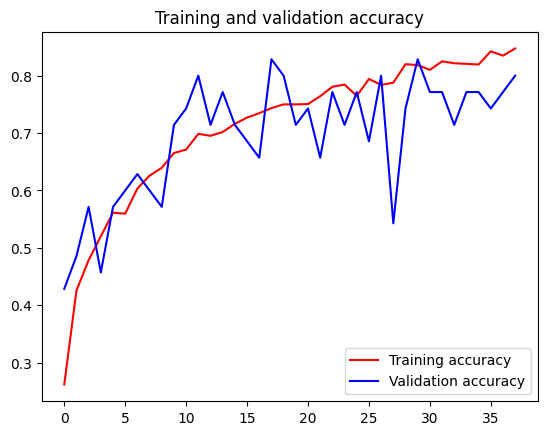

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt



# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Model Prediction



In [12]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}


1/1 [==============================] - 0s 314ms/step


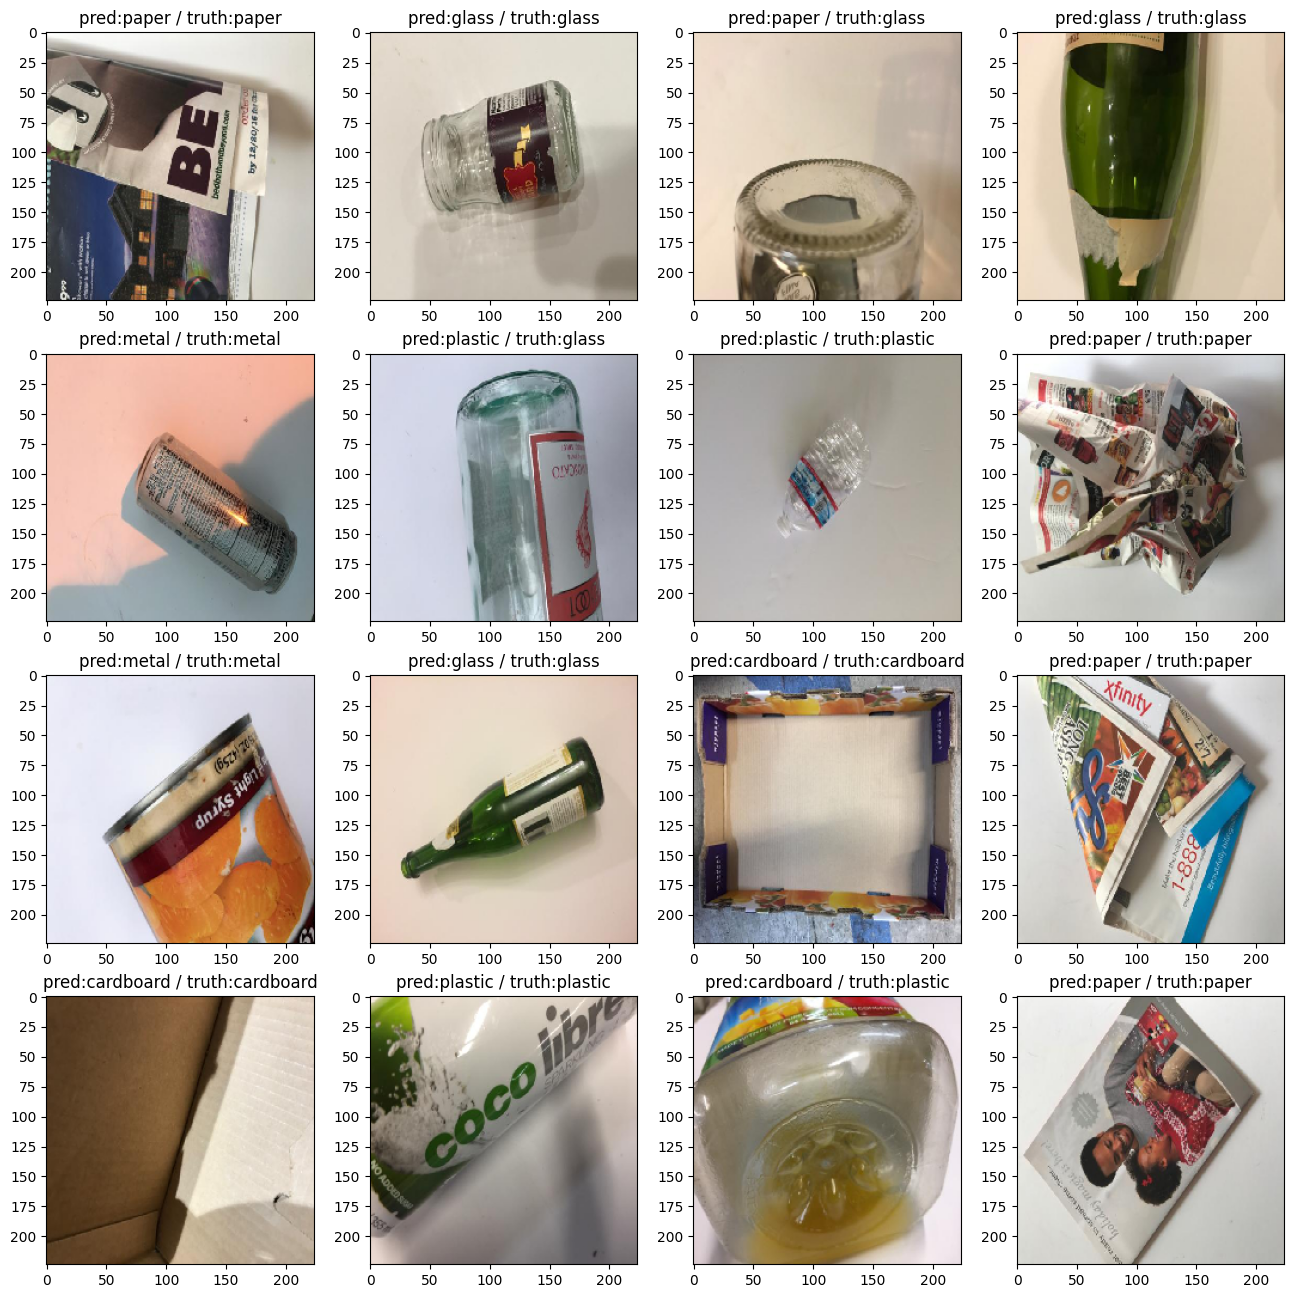

In [13]:
import numpy as np

test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [14]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('new_model.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('new_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0